In [11]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# compute a gravity model with population and distance
def gravity(distances, nodes, alpha=1, beta=1):
    # compute the denominator
    denominator = 0
    for i in distances:
        for j in distances[i]:
            denominator += (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015'])
    
    # compute the gravity model
    gravity = {}
    for i in distances:
        gravity[i] = {}
        for j in distances[i]:
            gravity[i][j] = (np.power(distances[i][j], -float(beta)) * nodes.loc[i, 'Pop2015'] * nodes.loc[j, 'Pop2015']) / denominator
    
    return gravity

# wrap it into a data frame
def flow_dataframe(flows):
    df = pd.DataFrame(flows).reset_index().melt(id_vars='index', var_name='to', value_name='flow')
    df = df.reset_index(drop=True).rename(columns={'index':'from'})
    df = df[df['from']!=df['to']].reset_index(drop=True)
    return df

In [13]:
# read in the data
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')
risks = pd.read_csv("../data/EDIndex20221202.csv")

In [14]:
# make the network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB'])

# add the node attributes
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))


In [15]:
# Dakar to Bangladesh as the megaregion
start_stop = nodes[(nodes['agglosName'] == "Dakar") | (nodes['agglosName'] == "Lagos")].Agglomeration_ID.to_list()

# how long is the shortest path?
nx.shortest_path_length(G, source = start_stop[0], target = start_stop[1], weight = 'l')


2945.1912940587954

In [16]:
# 3500 adds a buffer
%time distances = dict(nx.all_pairs_dijkstra_path_length(G, weight='l', cutoff=3500))

CPU times: user 23.4 s, sys: 136 ms, total: 23.5 s
Wall time: 23.5 s


In [17]:
# get the index values for roads, which are labeled as 'road' in the 'agglosName' attribute with the node data
junctions = [n for n, d in G.nodes(data=True) if d['agglosName']=='road']

# remove entries in the dictionary that are junctions, del for delete
for k in junctions:
    del distances[k]

# for each entry in distances, remove the self-loops
for i in distances:
    del distances[i][i]

In [18]:
nodes = nodes.set_index('Agglomeration_ID')
nodes.head()

,agglosName,x,y,Pop2015,ISO3,Region,Between,degree
Agglomeration_ID,,,,,,,,
2320,Cairo,31.324,30.130,22995802,EGY,North,6.979617e+07,6
5199,Lagos,3.316,6.668,11847635,NGA,West,3.127663e+07,4
7098,Onitsha,6.928,5.815,8530514,NGA,West,2.110388e+07,6
4220,Johannesburg,28.016,-26.050,8314220,ZAF,South,3.568974e+07,5
4858,Kinshasa,15.293,-4.408,7270000,COD,Central,1.119784e+06,4


In [19]:
flows = {}

# check multiple gravity models
for i in np.arange(1, 2.1, 0.1):
    %time temp = flow_dataframe(gravity(distances, nodes, beta=i))

    # add the flows to the dictionary
    flows[i] = temp

# make a data frame
flows = pd.concat(flows, names=['beta', 'index']).reset_index(level=1, drop=True).reset_index()

CPU times: user 1min 32s, sys: 272 ms, total: 1min 33s
Wall time: 1min 33s
CPU times: user 1min 33s, sys: 98.2 ms, total: 1min 33s
Wall time: 1min 33s
CPU times: user 1min 33s, sys: 94.9 ms, total: 1min 33s
Wall time: 1min 33s
CPU times: user 1min 33s, sys: 96.3 ms, total: 1min 33s
Wall time: 1min 33s
CPU times: user 1min 32s, sys: 128 ms, total: 1min 33s
Wall time: 1min 33s
CPU times: user 1min 33s, sys: 136 ms, total: 1min 33s
Wall time: 1min 33s
CPU times: user 1min 32s, sys: 144 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 1min 32s, sys: 142 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 1min 32s, sys: 109 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 1min 32s, sys: 102 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 1min 32s, sys: 96.7 ms, total: 1min 32s
Wall time: 1min 32s


In [22]:
# filter flows out flows that are less than 0 
flows_trimmed = flows[flows['flow']>0].reset_index(drop=True)

In [27]:
# get shortest paths
paths = dict(nx.all_pairs_dijkstra_path(G, weight='l', cutoff=3500))

In [28]:
# convert paths to a dataframe, reset the index and melt the data
paths = pd.DataFrame(paths).reset_index().melt(id_vars='index', var_name='to', value_name='path')
paths = paths.reset_index(drop=True).rename(columns={'index':'from'})
paths = paths[paths['from'].isin(flows_trimmed['from']) & paths['to'].isin(flows_trimmed['to'])].reset_index(drop=True)


In [29]:
# remove self loops
paths = paths[paths['from']!=paths['to']].reset_index(drop=True)
# remove nan values
paths = paths[paths['path'].notnull()].reset_index(drop=True)

In [30]:
# map over paths to get pairs in a moving window
def get_pairs(path):
    pairs = []
    for i in range(len(path)-1):
        pairs.append((path[i], path[i+1]))
    return pairs

# map over paths to get pairs in a moving window
paths['pairs'] = paths['path'].map(get_pairs)

In [31]:
# expand pairs column so that each element of the list becomes a row
paths = paths.explode('pairs').reset_index(drop=True)

# rename from, to columns into origin and destination
paths = paths.rename(columns={'from':'origin', 'to':'destination'})

# split pairs into from and to columns
paths[['from', 'to']] = pd.DataFrame(paths['pairs'].tolist(), index=paths.index)
paths.head()

,origin,destination,path,pairs,from,to
0,2333,8211,"[8211, 2333]","(8211, 2333)",8211,2333
1,5425,8211,"[8211, 5425]","(8211, 5425)",8211,5425
2,8208,8211,"[8211, 8208]","(8211, 8208)",8211,8208
3,3833,8211,"[8211, 2333, 3833]","(8211, 2333)",8211,2333
4,3833,8211,"[8211, 2333, 3833]","(2333, 3833)",2333,3833


In [37]:
def impute_flows(paths, flows, identifier):
    # join the paths with the flows dataframe
    flows_imputed = paths.merge(flows, left_on=['origin', 'destination'], right_on=['from', 'to'], how='left')

    # rename from_x and to_x columns into from and to
    flows_imputed = flows_imputed.rename(columns={'from_x':'from', 'to_x':'to'})

    # select from, to, flow, flow_delayed, flow_reduced columns
    flows_imputed = flows_imputed[['from', 'to', 'flow']]

    # group by from, to and sum the flows
    flows_imputed = flows_imputed.groupby(['from', 'to'], as_index=False).sum()
    flows_imputed['beta'] = identifier

    return flows_imputed

In [38]:
# loop through beta values and impute flows
flows_imputed = []
for i in flows_trimmed['beta'].unique():
    flows_imputed.append(impute_flows(paths, flows_trimmed[flows_trimmed['beta']==i], i))

# concatenate the data frames
flows_imputed = pd.concat(flows_imputed, ignore_index=True)

In [95]:
# nodes.reset_index(inplace=True)
# merge the data frames
flows_imputed = flows_imputed.merge(nodes[['Agglomeration_ID', 'Region']].rename(columns={'Agglomeration_ID': 'from', 'Region': "from_region"}), left_on='from', right_on='from', how='left')
flows_imputed = flows_imputed.merge(nodes[['Agglomeration_ID', 'Region']].rename(columns={'Agglomeration_ID': 'to', 'Region': "to_region"}), left_on='to', right_on='to', how='left')

# add a column that indicates whether the flow is a crossing
flows_imputed['crossing'] = flows_imputed['from_region'] != flows_imputed['to_region']

# add a column that indicates the region
region = []

for row in flows_imputed.iterrows():
    if row[1]['crossing']: 
        region = np.append(region, "crossing")
    else: 
        region = np.append(region, row[1]['from_region'])

flows_imputed['region'] = region
flows_imputed.head()

,from,to,flow,beta,from_region,to_region,crossing,region
0,1,1230,0.000992,1.0,North,North,False,North
1,1,1891,0.019871,1.0,North,North,False,North
2,1,2320,0.038737,1.0,North,North,False,North
3,1,1002523,0.000856,1.0,North,North,False,North
4,1,1046839,0.000937,1.0,North,North,False,North


In [97]:
flows_imputed.drop(columns=['from_region', 'to_region', 'crossing'], inplace=True)

In [105]:
joined = flows_imputed.merge(risks, left_on=['from', 'to'], right_on=['from', 'to'], how='left')
joined = joined[['from', 'to', 'flow', 'beta', 'region', 'index']].rename(columns={'index': 'risk'})
joined = joined.fillna(0)

crosswalk = {
    'region': ['Central', 'East', 'North', 'South', 'West', 'crossing'],
    'color': ['#a0e491', '#48ffef', '#ef72aa', '#00cff9', '#953f1f', '#7c7c7c']
}

crosswalk = pd.DataFrame(crosswalk)

joined = joined.merge(crosswalk, left_on='region', right_on='region', how='left')

In [215]:
import colorsys

def hex_to_hsl(hex_color):
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r /= 255.0
    g /= 255.0
    b /= 255.0
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return h, s, l

def hsl_to_hex(h, s, l):
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    r = int(r * 255)
    g = int(g * 255)
    b = int(b * 255)
    return f'#{r:02x}{g:02x}{b:02x}'

def vary_hue(hex_color, hue_offset):
    h, s, l = hex_to_hsl(hex_color)
    l = (l + hue_offset) % 1
    return hsl_to_hex(h, s, l)

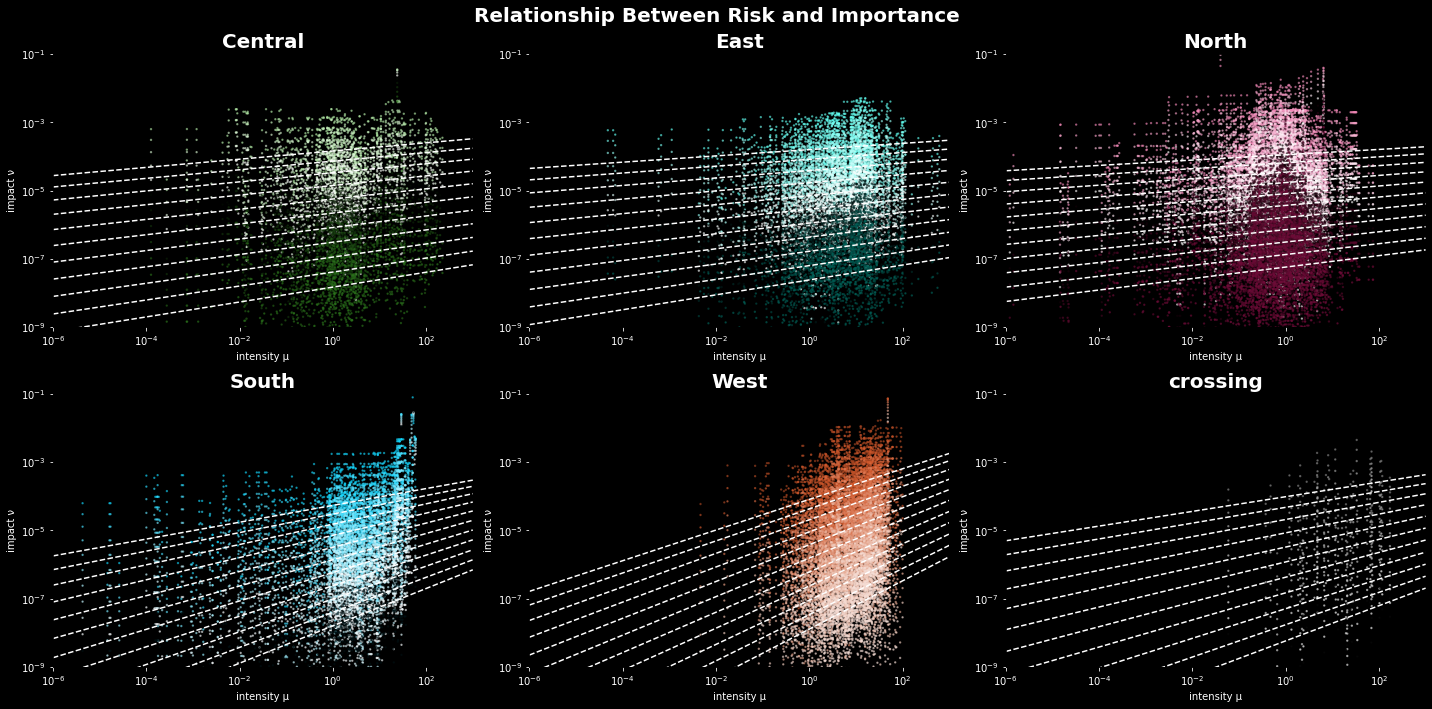

In [216]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), facecolor='k', tight_layout=True)

# ravel the axes so that we can loop through them
ax = ax.ravel()

# across each axis plot the data per region
for i, r in enumerate(np.unique(region)):
    off = 0.05
    for b in joined['beta'].unique():
        # vary the hue of the color
        hue = [vary_hue(color, off) for color in joined[(joined['region']==r) & (joined['beta']==b)]['color']]

        # increment the offset
        off += 0.05

        # plot the points as a 2d kernel density estimate
        joined[(joined['region']==r) & (joined['beta']==b)][['risk', 'flow']].plot('risk', 'flow', color=hue, kind='scatter', ax=ax[i], alpha=0.5, s=2)

    # clean it up
    ax[i].set_facecolor('k')
    ax[i].set_title(r, color='w', size=20, weight='bold')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

    # make sure that the axis ticks are the same across all plots
    ax[i].set_ylim([10**-9, 10**-1])
    ax[i].set_xlim([10**-6, 10**3])

    # sparsify the ticks
    ax[i].set_yticks([10**-9, 10**-7, 10**-5, 10**-3, 10**-1])
    ax[i].set_xticks([10**-6, 10**-4, 10**-2, 10**0, 10**2])

    ax[i].set_xlabel("intensity " + u"\u03BC", color="w")
    ax[i].set_ylabel("impact " + u"\u03BD", color="w")
    ax[i].tick_params(axis='x', colors='w')
    ax[i].tick_params(axis='y', colors='w')

    # add a line of best fit 
    from scipy.stats import linregress
    for b in joined['beta'].unique():
        temp = joined[joined['region']==r]
        temp = temp[temp['flow'] > 0]
        temp = temp[temp['risk'] > 0]
        temp = temp[temp['beta']==b]

        # calculate the line of best fit
        slope, intercept, r_value, p_value, std_err = linregress(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))

        x = np.linspace(10**-6, 10**3, 100)
        y = np.exp(intercept) * x**slope
        ax[i].plot(x, y, color='w', linestyle='--')

    # add the pearson correlation coefficient to the bottom left of each plot
    # from scipy.stats import pearsonr
    # temp = joined[joined['flow'] > 0]
    # temp = temp[temp['risk'] > 0]
    # temp = temp[temp['region']==r]
    # corr = pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[0].astype(float), pearsonr(np.log(temp[temp['region']==r]['risk']), np.log(temp[temp['region']==r]['flow']))[1].astype(float)
    # ax[i].text(0.05, 0.05, 'r = ' + str(round(corr[0], 2)), color='w', transform=ax[i].transAxes, weight='bold', size=20)

fig.suptitle('Relationship Between Risk and Importance', color='w', size=20, weight='bold')
fig.savefig('../viz/africapolis-riskvflow-sensitivity.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')